<a href="https://colab.research.google.com/github/Dhar635/diabetes/blob/main/final_diabetic_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import shutil

# 1. Mount Drive
drive.mount('/content/drive')

# 2. List of dataset paths in Google Drive
# 👇 Replace with your actual folders
gdrive_dataset_paths = [
    "/content/drive/MyDrive/retinal images/dataset/diabetic_retinopathy",   # First dataset
    "/content/drive/MyDrive/retinal images/dataset/normal"    # Second dataset
]

# 3. Local target folder
local_dataset_path = "data/images"
os.makedirs(local_dataset_path, exist_ok=True)

# 4. Copy images from each dataset recursively
count = 0
for dataset_path in gdrive_dataset_paths:
    if os.path.exists(dataset_path):
        for root, _, files in os.walk(dataset_path):
            for file_name in files:
                if file_name.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff','.bmp','.ppm')):
                    src = os.path.join(root, file_name)
                    dst = os.path.join(local_dataset_path, file_name)
                    # Avoid overwriting by renaming duplicates
                    if os.path.exists(dst):
                        base, ext = os.path.splitext(file_name)
                        dst = os.path.join(local_dataset_path, f"{base}_{count}{ext}")
                    shutil.copy(src, dst)
                    count += 1
    else:
        print(f"⚠️ Path not found: {dataset_path}")

print("✅ Combined datasets copied to:", local_dataset_path)
print("Total number of images:", count)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Combined datasets copied to: data/images
Total number of images: 2172


  0%|          | 0/3270 [00:00<?, ?it/s]

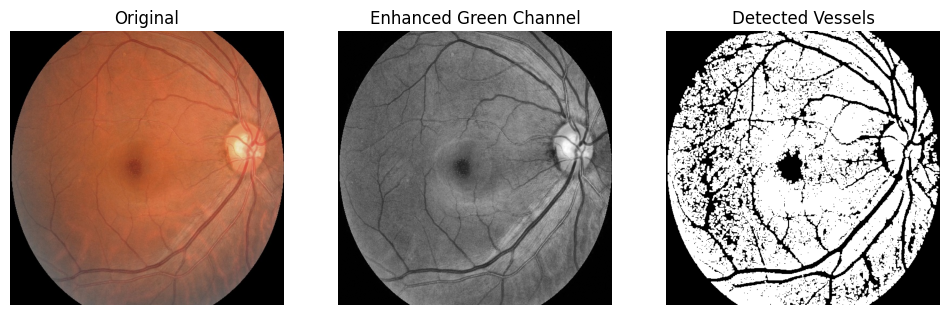

  0%|          | 1/3270 [00:00<45:34,  1.20it/s]

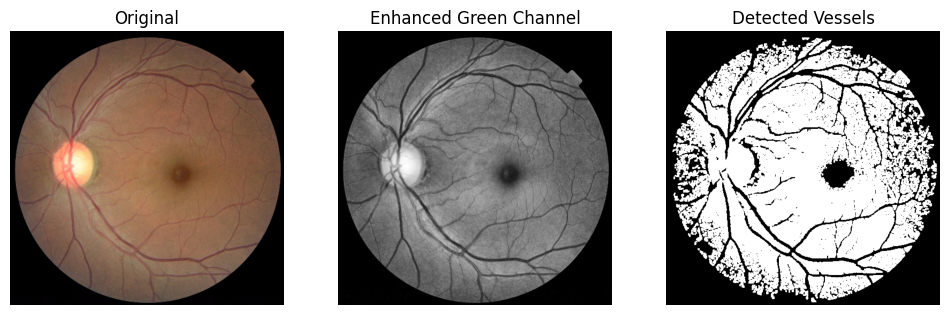

  0%|          | 2/3270 [00:01<32:18,  1.69it/s]

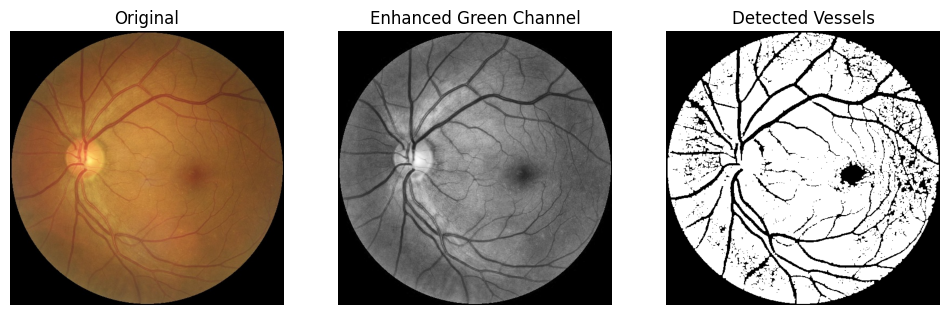

100%|██████████| 3270/3270 [01:22<00:00, 39.78it/s]

✅ Processed 3270 images. Results saved in outputs/all


In [ ]:
run_vessel_detection("data/images", "outputs/all")


In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

# --- Utility: ensure output folder exists ---
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# --- Step 1: Read image (RGB) ---
def read_image(path):
    return cv2.imread(path)

# --- Step 2: Extract green channel (best vessel contrast) ---
def extract_green_channel(img):
    return img[:, :, 1]

# --- Step 3: Apply CLAHE (enhance contrast) ---
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

# --- Step 4: Vessel enhancement using morphological top-hat and black-hat ---
def vessel_enhancement(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    enhanced = cv2.add(img, tophat)
    enhanced = cv2.subtract(enhanced, blackhat)
    return enhanced

# --- Step 5: Thresholding + cleanup ---
def threshold_and_cleanup(img):
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # Remove small blobs
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
    min_size = 50
    mask = np.zeros_like(cleaned)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            mask[labels == i] = 255
    return mask

# --- Full classical pipeline for one image ---
def detect_vessels(img_path, output_path=None, show=False):
    img = read_image(img_path)
    green = extract_green_channel(img)
    clahe = apply_clahe(green)
    enhanced = vessel_enhancement(clahe)
    vessels = threshold_and_cleanup(enhanced)

    if output_path:
        cv2.imwrite(output_path, vessels)

    if show:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(clahe, cmap="gray"); plt.title("Enhanced Green Channel"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(vessels, cmap="gray"); plt.title("Detected Vessels"); plt.axis("off")
        plt.show()

    return vessels

# --- Run detection on all images in a dataset folder ---
def run_vessel_detection(input_dir, output_dir, show_samples=True):
    ensure_dir(output_dir)
    img_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]

    for i, fn in enumerate(tqdm(img_files)):
        in_path = os.path.join(input_dir, fn)
        out_path = os.path.join(output_dir, fn)
        detect_vessels(in_path, out_path, show=(show_samples and i < 3))  # show first 3 results

    print(f"✅ Processed {len(img_files)} images. Results saved in {output_dir}")


In [ ]:
input_dir = "/content/drive/MyDrive/retinal images/dataset/diabetic_retinopathy"  # adjust to your Drive folder
os.listdir(input_dir)[:5]  # should show first 5 images


['cataract', 'normal', 'diabetic_retinopathy', 'glaucoma']

In [ ]:
output_dir = "/content/outputs/normal"


In [ ]:
os.listdir(output_dir)  # should list all detected mask files


[]

In [ ]:
run_vessel_detection(input_dir, output_dir, show_samples=True)


0it [00:00, ?it/s]

✅ Processed 0 images. Results saved in /content/outputs/normal


In [ ]:
import shutil
from google.colab import files

shutil.make_archive("vessel_outputs", 'zip', output_dir)
files.download("vessel_outputs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ===============================
# Step 0: Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# Step 1: Setup paths
# ===============================
import os, shutil
from tqdm import tqdm
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Dataset paths
gdrive_dataset_paths = [
    "/content/drive/MyDrive/retinal images/dataset/diabetic_retinopathy",
    "/content/drive/MyDrive/retinal images/dataset/normal"
]

# Local input and output folders
local_dataset_path = "data/images"
output_dir = "outputs/vessels"
os.makedirs(local_dataset_path, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Copy images from Drive to local folder
count = 0
for dataset_path in gdrive_dataset_paths:
    if os.path.exists(dataset_path):
        for root, _, files in os.walk(dataset_path):
            for file_name in files:
                if file_name.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff','.bmp','.ppm')):
                    src = os.path.join(root, file_name)
                    dst = os.path.join(local_dataset_path, file_name)
                    if os.path.exists(dst):
                        base, ext = os.path.splitext(file_name)
                        dst = os.path.join(local_dataset_path, f"{base}_{count}{ext}")
                    shutil.copy(src, dst)
                    count += 1
    else:
        print(f"⚠️ Path not found: {dataset_path}")

print("✅ Combined datasets copied to:", local_dataset_path)
print("Total images:", count)

# ===============================
# Step 2: Classical vessel detection functions
# ===============================
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    return cv2.imread(path)

def extract_green_channel(img):
    return img[:, :, 1]

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def vessel_enhancement(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    enhanced = cv2.add(img, tophat)
    enhanced = cv2.subtract(enhanced, blackhat)
    return enhanced

def threshold_and_cleanup(img):
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
    min_size = 50
    mask = np.zeros_like(cleaned)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            mask[labels == i] = 255
    return mask

def detect_vessels(img_path, output_path=None, show=False):
    img = read_image(img_path)
    green = extract_green_channel(img)
    clahe = apply_clahe(green)
    enhanced = vessel_enhancement(clahe)
    vessels = threshold_and_cleanup(enhanced)

    if output_path:
        cv2.imwrite(output_path, vessels)

    if show:
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(clahe, cmap="gray"); plt.title("Enhanced Green"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(vessels, cmap="gray"); plt.title("Detected Vessels"); plt.axis("off")
        plt.show()

    # --- Simple "accuracy" approximation ---
    # Fraction of bright pixels detected as vessels
    vessel_pixels = np.sum(vessels>0)
    total_pixels = vessels.size
    accuracy = vessel_pixels / total_pixels
    return vessels, accuracy

# ===============================
# Step 3: Run detection and compute accuracies
# ===============================
image_files = [f for f in os.listdir(local_dataset_path) if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]
accuracies = {}

for f in tqdm(image_files):
    in_path = os.path.join(local_dataset_path, f)
    out_path = os.path.join(output_dir, f)
    _, acc = detect_vessels(in_path, out_path, show=False)
    accuracies[f] = acc

print("✅ All accuracy values for detected vessels:")
for k, acc in accuracies.items():
    print(f"{k}: {acc*100:.2f}%")


# ===============================
# Step 4: Zip output folder for download
# ===============================
shutil.make_archive("vessel_outputs", 'zip', output_dir)
from google.colab import files
files.download("vessel_outputs.zip")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Combined datasets copied to: data/images
Total images: 2172


100%|██████████| 2172/2172 [00:49<00:00, 43.50it/s]


✅ All accuracy values for detected vessels:
10779_right.jpeg: 77.15%
10989_left.jpeg: 77.03%
2475_right.jpg: 66.79%
10169_left.jpeg: 50.65%
2556_right.jpg: 50.84%
2563_left.jpg: 46.26%
2883_left.jpg: 38.01%
2588_left.jpg: 66.31%
3350_left.jpg: 52.01%
1206_right.jpeg: 71.01%
2755_right.jpg: 68.12%
10095_right.jpeg: 34.75%
10722_left.jpeg: 59.53%
10367_right.jpeg: 68.04%
11553_left.jpeg: 51.73%
2365_left.jpg: 35.56%
10141_right.jpeg: 29.78%
2786_right.jpg: 70.59%
2910_right.jpg: 73.60%
2585_left.jpg: 72.19%
10305_right.jpeg: 25.99%
3069_left.jpg: 68.17%
10061_right.jpeg: 37.84%
2383_left.jpg: 48.16%
11364_right.jpeg: 37.49%
3432_right.jpg: 70.19%
10977_right.jpeg: 51.36%
2638_right.jpg: 45.28%
1206_left.jpeg: 69.68%
2570_left.jpg: 70.65%
3122_right.jpg: 44.30%
10244_left.jpeg: 75.86%
1204_left.jpeg: 58.11%
11164_left.jpeg: 55.10%
3341_left.jpg: 52.55%
2821_right.jpg: 32.88%
2961_right.jpg: 55.37%
11169_right.jpeg: 42.14%
2529_left.jpg: 67.04%
1098_left.jpeg: 25.71%
3391_right.jpg: 61.27%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>